# Download and visualize Foursquare/Swarm check-in history

  1. Get a Foursquare OAuth token: https://developer.foursquare.com/docs/explore#req=users/self/checkins
  2. Create a file called keys.py in the same directory as these IPython notebooks
  3. Edit your keys.py file to add foursquare_oauth_token = 'your-token-here'
  4. Run this script
  5. When it's done, your raw checkin history will be saved as data/foursqure-checkins.json and your cleaned dataset for subsequent analysis will be saved as data/foursquare-location-history.csv

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import requests, json
from datetime import datetime as dt
from mpl_toolkits.basemap import Basemap
from keys import foursquare_oauth_token

%matplotlib inline
title_fontsize = 14

In [2]:
# the json file will contain the entire downloaded check-ins data set
json_file = 'data/foursqure-checkins.json'

# the csv file will contain the cleaned data used for subsequent analysis
csv_file = 'data/foursquare-location-history.csv'

# api endpoint to download your checkin history
url_template = 'https://api.foursquare.com/v2/users/self/checkins?limit=250&v=20160104&offset={}&oauth_token={}'

In [3]:
# you can only pull 250 records at a time from the api, so use offset to increment by 250 in a loop
offset = 0
data = []
while True:
    print(offset, end=' ')
    response = requests.get(url_template.format(offset, foursquare_oauth_token))
    if len(response.json()['response']['checkins']['items']) == 0:
        break #whenever api returns no rows, offset value has exceeded total records so we're done
    data.append(response.json())
    offset += 250

0 250 500 750 1000 1250 1500 1750 2000 2250 2500 2750 3000 3250 3500 3750 4000 4250 

In [4]:
# save the entire raw downloaded check-ins data set as json
with open(json_file, 'w') as f:
    f.write(json.dumps(data, indent=2))

## Now parse the responses and load into a dataframe

In [5]:
# location_components is the list of pieces we're interested in pulling out of the dataset
location_components = ['city', 'state', 'country', 'lat', 'lng']
rows = []
for response in data:
    for item in response['response']['checkins']['items']:
        try:
            checkin = {}
            checkin['venue_name'] = item['venue']['name']
            checkin['created_at'] = item['createdAt']
            
            if len(item['venue']['categories']) > 0:
                checkin['category'] = item['venue']['categories'][0]['name']
                
            for component in location_components:
                if component in item['venue']['location']:
                    checkin[component] = item['venue']['location'][component]
                else:
                    checkin[component] = np.nan
            rows.append(checkin)
        except:
            pass

In [6]:
df_full = pd.DataFrame(rows)

# convert unix timestamp to date and time, then drop the timestamp column
df_full['datetime'] = df_full['created_at'].map(lambda x: dt.fromtimestamp(x).strftime('%Y-%m-%d %H:%M'))
df_full = df_full.drop('created_at', axis=1)

# rename lng column to lon
df_full = df_full.rename(columns={'lng':'lon'})

In [7]:
# remove health care and private homes for privacy purposes
terms = ['doctor', 'emergency', 'urgent', 'hospital', 'medical', 'private']
mask = False
for term in terms:
    mask = mask | df_full['category'].str.lower().str.contains(term)
    
df_filtered = df_full[~mask].copy()

## Visualize the check-in data

In [8]:
# create day/hour/month columns for time series visualization
df_filtered['weekday'] = df_filtered['datetime'].map(lambda x: dt.strptime(x, '%Y-%m-%d %H:%M').weekday())
df_filtered['hour'] = df_filtered['datetime'].map(lambda x: dt.strptime(x, '%Y-%m-%d %H:%M').hour)
df_filtered['month'] = df_filtered['datetime'].str[0:7]

In [9]:
# rename a couple lengthy values so they look nicer as labels
df_filtered['category'] = df_filtered['category'].str.replace('College Academic Building', 'College Bldg')
df_filtered['venue_name'] = df_filtered['venue_name'].str.replace('Environmental Design Library', 'Env Design Library')
df_filtered['venue_name'] = df_filtered['venue_name'].str.replace('Wurster Hall / College of Environmental Design', 'Wurster Hall')
df_filtered['venue_name'] = df_filtered['venue_name'].str.replace('Oakland International Airport \(OAK\)', 'Oakland Int Airport')

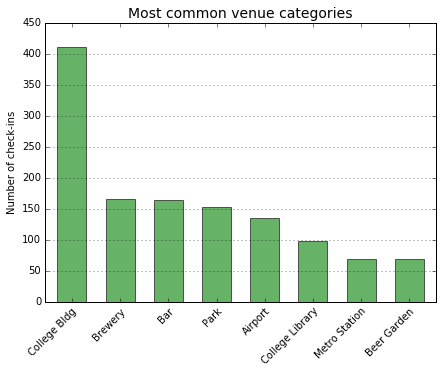

In [10]:
# most common venue categories
countdata = df_filtered['category'].value_counts().head(8)
ax = countdata.plot(kind='bar', figsize=[7, 5], width=0.6, alpha=0.6, 
                    color='g', edgecolor='k', grid=False)
ax.set_xticklabels(countdata.index, rotation=45, rotation_mode='anchor', ha='right')
ax.yaxis.grid(True)
ax.set_title('Most common venue categories', fontsize=title_fontsize)
ax.set_ylabel('Number of check-ins')

plt.savefig('images/foursquare_common_categories.png', dpi=96, bbox_inches='tight')
plt.show()

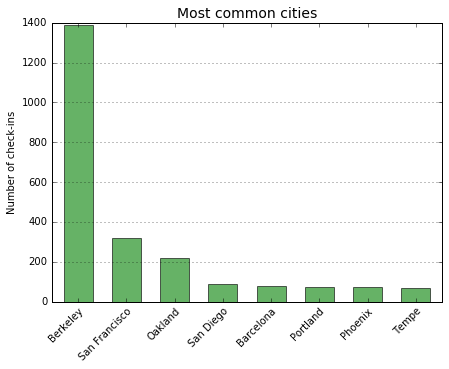

In [11]:
# most common cities (and drop N/A)
countdata = df_filtered['city'].value_counts().head(8)
ax = countdata.plot(kind='bar', figsize=[7, 5], width=0.6, alpha=0.6, 
                    color='g', edgecolor='k', grid=False)
ax.set_xticklabels(countdata.index, rotation=45, rotation_mode='anchor', ha='right')
ax.yaxis.grid(True)
ax.set_title('Most common cities', fontsize=title_fontsize)
ax.set_ylabel('Number of check-ins')

plt.savefig('images/foursquare_common_cities.png', dpi=96, bbox_inches='tight')
plt.show()

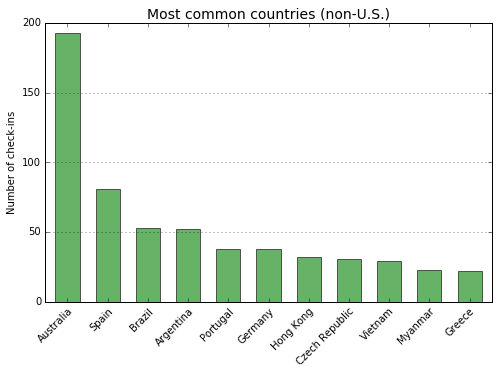

In [12]:
# most common countries, other than the US
countdata = df_filtered['country'].value_counts().iloc[1:12]
ax = countdata.plot(kind='bar', figsize=[8, 5], width=0.6, alpha=0.6, 
                    color='g', edgecolor='k', grid=False)
ax.set_xticklabels(countdata.index, rotation=45, rotation_mode='anchor', ha='right')
ax.yaxis.grid(True)
ax.set_title('Most common countries (non-U.S.)', fontsize=title_fontsize)
ax.set_ylabel('Number of check-ins')

plt.savefig('images/foursquare_common_countries.png', dpi=96, bbox_inches='tight')
plt.show()

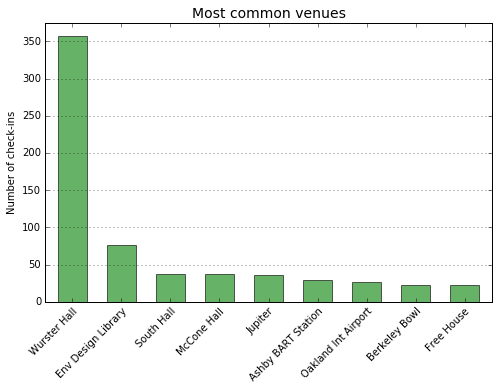

In [13]:
# venues with the most check-ins
countdata = df_filtered['venue_name'].value_counts().head(9)
ax = countdata.plot(kind='bar', figsize=[8, 5], width=0.6, alpha=0.6, 
                    color='g', edgecolor='k', grid=False)
ax.set_xticklabels(countdata.index, rotation=45, rotation_mode='anchor', ha='right')
ax.set_ylim(0, 375)
ax.yaxis.grid(True)
ax.set_title('Most common venues', fontsize=title_fontsize)
ax.set_ylabel('Number of check-ins')

plt.savefig('images/foursquare_common_venues.png', dpi=96, bbox_inches='tight')
plt.show()

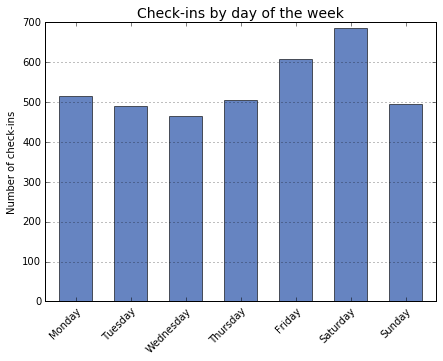

In [14]:
# check-ins by the day of the week
countdata = df_filtered.groupby('weekday')['weekday'].count()
countdata.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = countdata.plot(kind='bar', figsize=[7, 5], width=0.6, alpha=0.6, 
                    color='#003399', edgecolor='k', grid=False)
ax.set_xticklabels(countdata.index, rotation=45, rotation_mode='anchor', ha='right')
ax.yaxis.grid(True)
ax.set_title('Check-ins by day of the week', fontsize=title_fontsize)
ax.set_ylabel('Number of check-ins')

plt.savefig('images/foursquare_checkins_weekday.png', dpi=96, bbox_inches='tight')
plt.show()

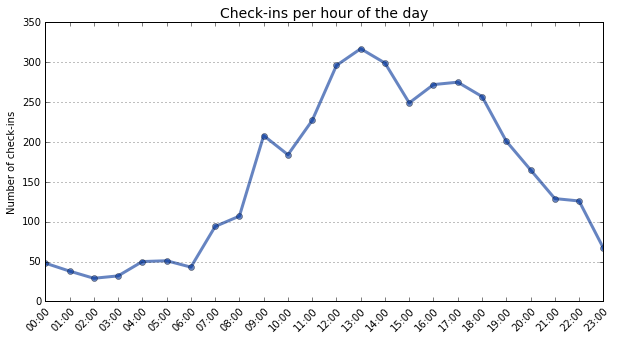

In [15]:
# check-ins by the hour of the day
countdata = df_filtered.groupby('hour')['hour'].count()
xlabels = ['{:02}:00'.format(x) for x in countdata.index]
ax = countdata.plot(kind='line',
                    figsize=[10, 5],
                    linewidth='3', 
                    alpha=0.6,
                    marker='o',
                    color='#003399')
ax.yaxis.grid(True)
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')
ax.set_ylabel('Number of check-ins')
ax.set_xlabel('')
ax.set_title('Check-ins per hour of the day', fontsize=title_fontsize)

plt.savefig('images/foursquare_checkins_hour.png', dpi=96, bbox_inches='tight')
plt.show()

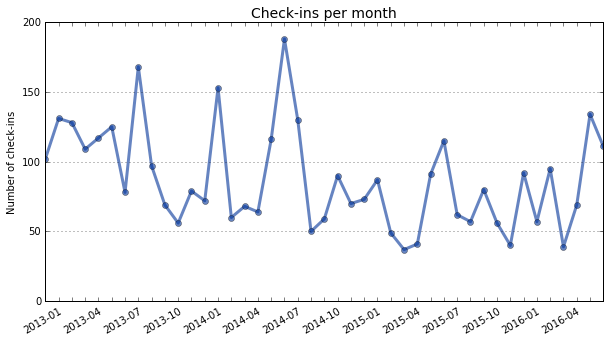

In [16]:
# check-ins by month
countdata = df_filtered.groupby('month')['month'].count()
xlabels = countdata.iloc[range(1, len(countdata), 3)].index
xlabels = [x if x in xlabels else '' for x in countdata.index]
ax = countdata.plot(kind='line',
                    figsize=[10, 5],
                    linewidth='3', 
                    alpha=0.6,
                    marker='o',
                    color='#003399')
ax.yaxis.grid(True)
ax.set_ylim([0,200])
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=30, rotation_mode='anchor', ha='right')
ax.set_ylabel('Number of check-ins')
ax.set_xlabel('')
ax.set_title('Check-ins per month', fontsize=title_fontsize)

plt.savefig('images/foursquare_checkins_month.png', dpi=96, bbox_inches='tight')
plt.show()

## Map the check-in data

In [17]:
# define map colors
land_color = '#f5f5f3'
water_color = '#cdd2d4'
coastline_color = '#999999'
border_color = '#999999'
meridian_color = '#aaaaaa'
marker_fill_color = '#cc3300'
marker_edge_color = 'None'

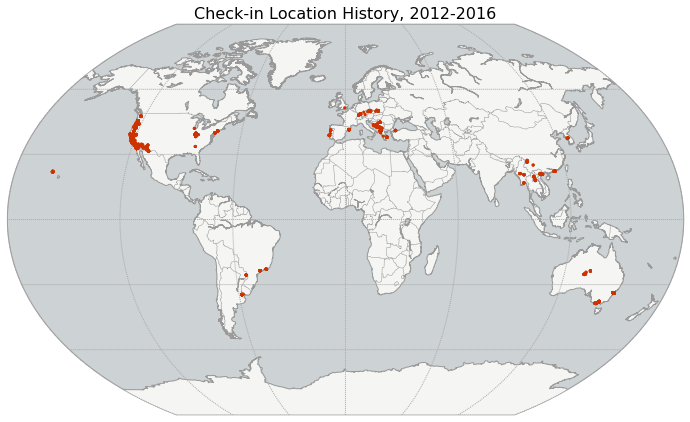

In [18]:
# create the plot
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, axisbg='#ffffff', frame_on=False)
years = df_filtered['datetime'].map(lambda x: int(x[0:4]))
ax.set_title('Check-in Location History, {}-{}'.format(years.min(), years.max()), fontsize=16)

# draw the basemap and its features
m = Basemap(projection='kav7', lon_0=0, resolution='l', area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)

# project our points from each dataset then concatenate and scatter plot them
x, y = m(df_filtered['lon'].values, df_filtered['lat'].values)
m.scatter(x, y, s=10, color=marker_fill_color, edgecolor=marker_edge_color, alpha=1, zorder=3)

# show the map
plt.savefig('images/foursquare_checkins_map.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Save to CSV

In [19]:
# remove multiple check-ins at the same location
df_unique = df_filtered.drop_duplicates(subset=['venue_name', 'lat', 'lon'], keep='last').copy()
#df_unique.head()

In [20]:
df_unique.to_csv(csv_file, index=False, encoding='utf-8')